**Importing Libraries**

In [ ]:
#libraries to be used
%matplotlib inline
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from textblob import TextBlob
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import sent_tokenize
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.graph_objects as go
import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


In [ ]:
from io import StringIO
import requests

#github hosted files
urls = [
    "https://github.com/Leonard-Simala/Datasets/raw/main/NSE_data_all_stocks_2013.csv",
    "https://github.com/Leonard-Simala/Datasets/raw/main/NSE_data_all_stocks_2014.csv",
    "https://github.com/Leonard-Simala/Datasets/raw/main/NSE_data_all_stocks_2015.csv",
    "https://github.com/Leonard-Simala/Datasets/raw/main/NSE_data_all_stocks_2016.csv",
    "https://github.com/Leonard-Simala/Datasets/raw/main/NSE_data_all_stocks_2017.csv",
    "https://github.com/Leonard-Simala/Datasets/raw/main/NSE_data_all_stocks_2018.csv",
    "https://github.com/Leonard-Simala/Datasets/raw/main/NSE_data_all_stocks_2019.csv",
    "https://github.com/Leonard-Simala/Datasets/raw/main/NSE_data_all_stocks_2020.csv"
  ]

# Dictionary to store dataframes
dataframes = {}

# Fetch and process each CSV file
for url in urls:
    # Fetch the content from the URL
    response = requests.get(url)

    # Check if the request was successful
    if response.status_code == 200:
        # Convert the content into a file-like object
        content = StringIO(response.text)

        # Extract the year from the URL
        year = url.split("_")[-1].split(".")[0]

        # Read the CSV file into a DataFrame
        df = pd.read_csv(content)

        # Store the DataFrame in the dictionary
        dataframes[year] = df
    else:
        print(f"Failed to fetch data from the URL: {url}")



**Loading data & combining into a DataFrame**

In [ ]:

# List to hold individual dataframes
dfs = []

# Fetch and process each CSV file
for url in urls:
    # Read CSV file into DataFrame
    df = pd.read_csv(url)
    # Append DataFrame to list
    dfs.append(df)

# Combine all dataframes into a single dataframe
combined_df = pd.concat(dfs, ignore_index=True)

# Select only numeric columns
numeric_columns = combined_df.select_dtypes(include=['number']).columns


**Data cleaning and conversion**

In [ ]:
# Convert non-numeric columns to numeric
def convert_columns_to_numeric(df, columns):
    for col in columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')  # 'coerce' to handle non-convertible values
#Columns to be converted to numeric
columns_to_convert = ['12m Low', '12m High', 'Day Low', 'Day High', 'Day Price', 'Previous', 'Change', 'Change%', 'Volume', 'Adjust']
convert_columns_to_numeric(combined_df, columns_to_convert)

# Drop the 'Adjust' column
combined_df = combined_df.drop('Adjust', axis=1)

# Select where the 'NAME' column matches 'Safaricom'
Safaricom = combined_df[combined_df['NAME'].isin(['Safaricom Plc'])].copy()

# Display the first few rows of the new DataFrame
Safaricom.head()


,DATE,CODE,NAME,12m Low,12m High,Day Low,Day High,Day Price,Previous,Change,Change%,Volume
54,2-Jan-13,SCOM,Safaricom Plc,23.5,33.5,5.00,5.15,5.10,5.00,0.10,NaN,NaN
113,3-Jan-13,SCOM,Safaricom Plc,23.5,33.5,5.10,5.25,5.15,5.10,0.05,NaN,NaN
172,4-Jan-13,SCOM,Safaricom Plc,23.5,33.5,5.15,5.35,5.25,5.15,0.10,NaN,NaN
231,7-Jan-13,SCOM,Safaricom Plc,23.5,33.5,5.20,5.45,5.35,5.25,0.10,NaN,NaN
290,8-Jan-13,SCOM,Safaricom Plc,23.5,33.5,5.40,5.85,5.60,5.35,0.25,NaN,NaN


In [ ]:
Safaricom.columns

Index(['DATE', 'CODE', 'NAME', '12m Low', '12m High', 'Day Low', 'Day High',
       'Day Price', 'Previous', 'Change', 'Change%', 'Volume'],
      dtype='object')

In [ ]:
Safaricom.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1993 entries, 54 to 134432
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   DATE       1993 non-null   object 
 1   CODE       1993 non-null   object 
 2   NAME       1993 non-null   object 
 3   12m Low    1993 non-null   float64
 4   12m High   1993 non-null   float64
 5   Day Low    1993 non-null   float64
 6   Day High   1993 non-null   float64
 7   Day Price  1993 non-null   float64
 8   Previous   1993 non-null   float64
 9   Change     1607 non-null   float64
 10  Change%    0 non-null      float64
 11  Volume     129 non-null    float64
dtypes: float64(9), object(3)
memory usage: 202.4+ KB


In [ ]:
Safaricom.isna().sum()

DATE            0
CODE            0
NAME            0
12m Low         0
12m High        0
Day Low         0
Day High        0
Day Price       0
Previous        0
Change        386
Change%      1993
Volume       1864
dtype: int64

In [ ]:
#Drop columns with Null values
Safaricom.drop(['Change%', 'Change', 'Volume'], axis=1, inplace=True)
Safaricom.head()

,DATE,CODE,NAME,12m Low,12m High,Day Low,Day High,Day Price,Previous
54,2-Jan-13,SCOM,Safaricom Plc,23.5,33.5,5.00,5.15,5.10,5.00
113,3-Jan-13,SCOM,Safaricom Plc,23.5,33.5,5.10,5.25,5.15,5.10
172,4-Jan-13,SCOM,Safaricom Plc,23.5,33.5,5.15,5.35,5.25,5.15
231,7-Jan-13,SCOM,Safaricom Plc,23.5,33.5,5.20,5.45,5.35,5.25
290,8-Jan-13,SCOM,Safaricom Plc,23.5,33.5,5.40,5.85,5.60,5.35


In [ ]:
#Set the Year Column as the Index
Safaricom = Safaricom.set_index('DATE')

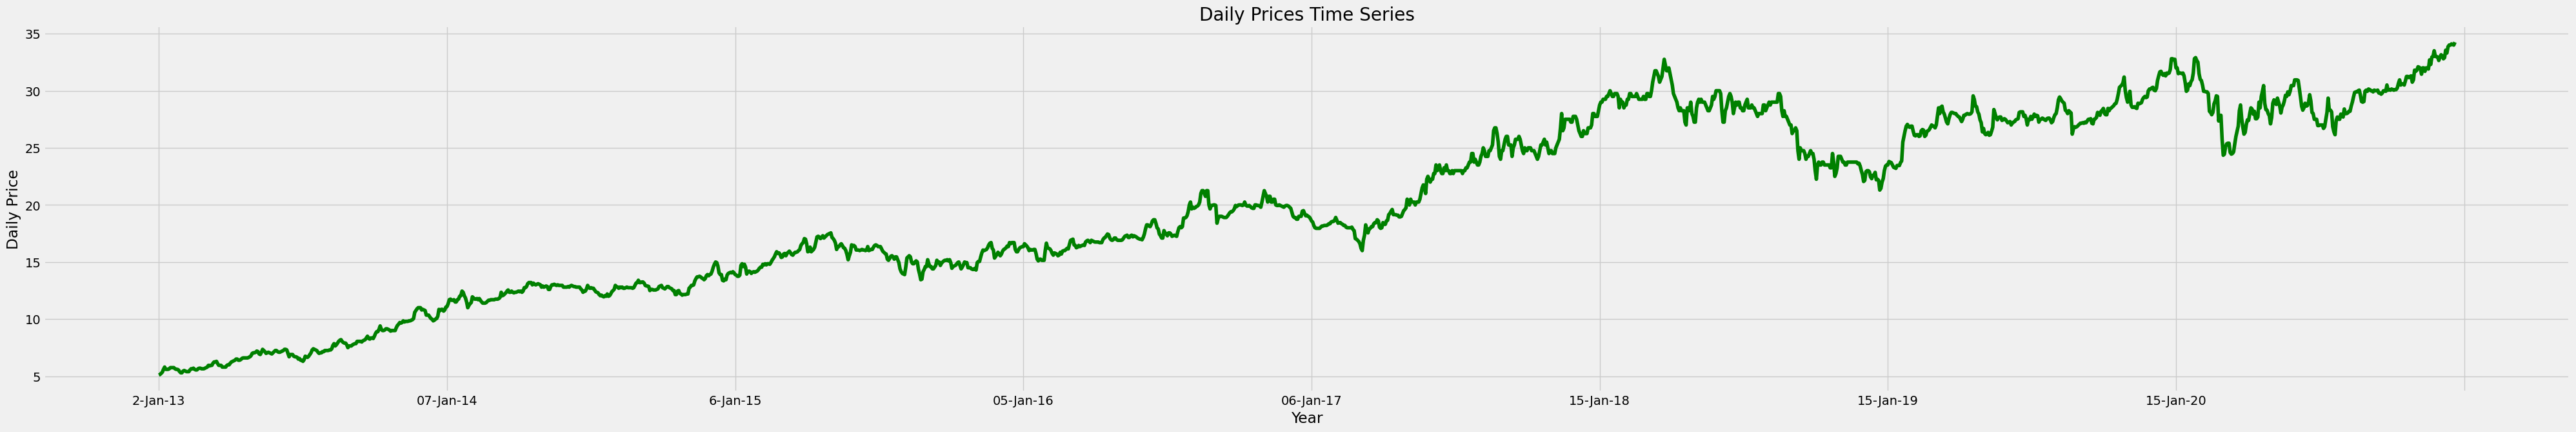

In [ ]:

import matplotlib.pyplot as plt
log_prices = np.log(Safaricom['Day Price'])
plt.style.use('fivethirtyeight')
df_subset = Safaricom['Day Price']

# Plot the time series
plt.figure(figsize=(45, 7))
ax = df_subset.plot(color='green', fontsize=14)

# Set plot title and axis labels
ax.set_title('Daily Prices Time Series')
ax.set_xlabel('Year')
ax.set_ylabel('Daily Price')

plt.show()


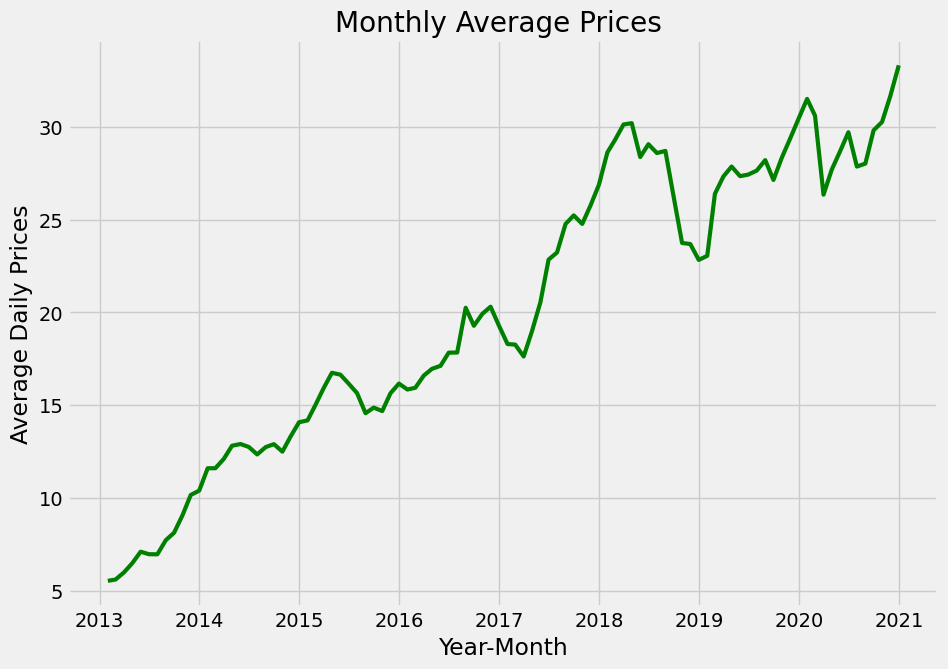

In [ ]:
# Convert the index to datetime format
Safaricom.index = pd.to_datetime(Safaricom.index)
# Resample the daily prices to monthly frequency and calculate the mean for each month
monthly_prices = Safaricom['Day Price'].resample('M').mean()

# Drop NaN values
monthly_prices = monthly_prices.dropna()

# Increase the figure size
plt.figure(figsize=(10, 7))  # Adjust the width and height as needed

# Plot the time series of monthly average prices
plt.plot(monthly_prices, color='green', linewidth=3)

# Set plot title and axis labels
plt.title('Monthly Average Prices ')
plt.xlabel('Year-Month')
plt.ylabel('Average Daily Prices')

plt.grid(True)

plt.show()


In [ ]:
monthly_prices=pd.DataFrame(monthly_prices)

In [ ]:
#Test stationarity
from statsmodels.tsa.stattools import adfuller

adf_stats = adfuller(monthly_prices['Day Price'])
x = 'the data is non stationary' if adf_stats[1] >= 0.05 else 'the data is stationary'
print(f'The p-value is: {round(adf_stats[1],2)} hence {x}')

The p-value is: 0.75 hence the data is non stationary


In [ ]:
#Make the data stationary
monthly_prices['Day Price_diff'] = monthly_prices['Day Price'].shift(1)
monthly_prices['Day Price_change'] = monthly_prices['Day Price'] - monthly_prices['Day Price_diff']
monthly_prices['Day Price'].dropna(inplace=True)
monthly_prices['Day Price'].head()

DATE
2013-01-31    5.525000
2013-02-28    5.592500
2013-03-31    5.978947
2013-04-30    6.470000
2013-05-31    7.095455
Freq: M, Name: Day Price, dtype: float64

In [ ]:
missing_values = monthly_prices['Day Price_change'].isnull().sum()
print(f"Number of missing values in 'Day Price_change' column: {missing_values}")


Number of missing values in 'Day Price_change' column: 1


In [ ]:
# Impute missing values with the mean
monthly_prices['Day Price_change'].fillna(monthly_prices['Day Price_change'].mean(), inplace=True)


In [ ]:
#Check for stationarity
from statsmodels.tsa.stattools import adfuller

adf_stats = adfuller(monthly_prices['Day Price_change'])
x = 'the data is non stationary' if adf_stats[1] >= 0.05 else 'the data is stationary'
print(f'The p-value is: {round(adf_stats[1],2)} hence {x}')

The p-value is: 0.0 hence the data is stationary


In [ ]:
monthly_prices.head()

,Day Price,Day Price_diff,Day Price_change
DATE,,,
2013-01-31,5.525000,NaN,0.292703
2013-02-28,5.592500,5.525000,0.067500
2013-03-31,5.978947,5.592500,0.386447
2013-04-30,6.470000,5.978947,0.491053
2013-05-31,7.095455,6.470000,0.625455


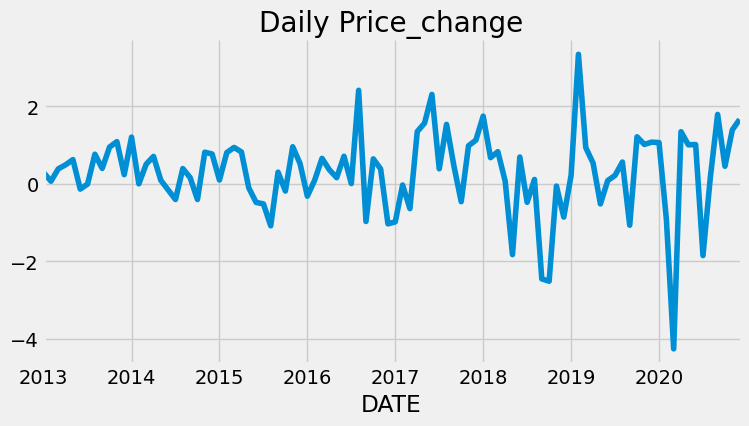

In [ ]:
# @title Day Price_change

from matplotlib import pyplot as plt
monthly_prices['Day Price_change'].plot(kind='line', figsize=(8, 4), title='Daily Price_change')
plt.gca().spines[['top', 'right']].set_visible(False)

**Daily Prices Forecasting**

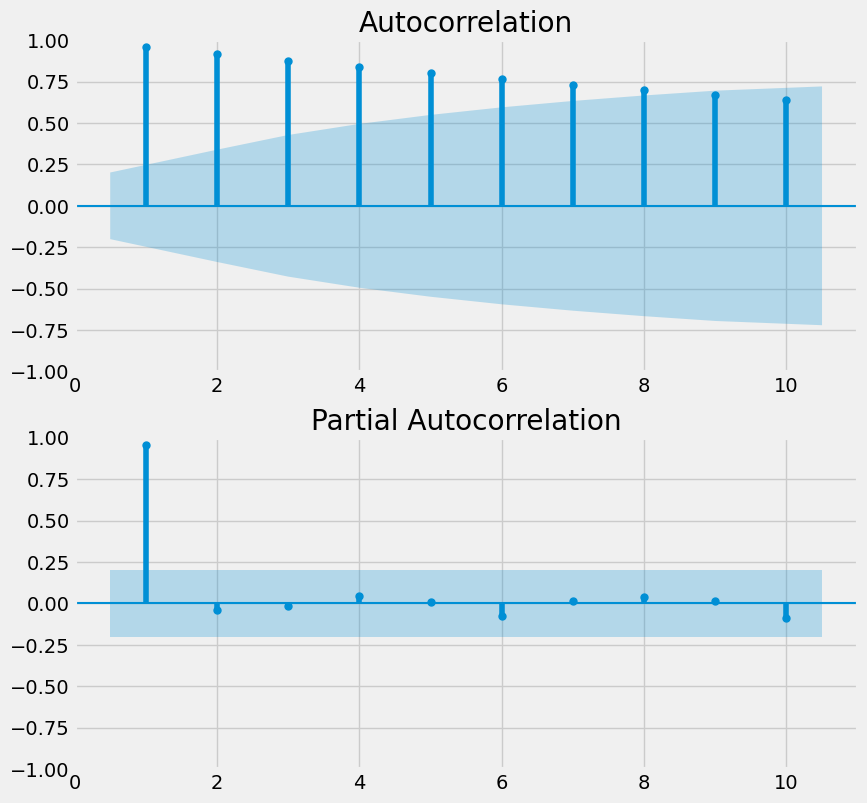

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Create figure
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(9,9))
# ACF plot
plot_acf(monthly_prices['Day Price_diff'].dropna(), lags=10, zero=False, ax=ax1,  linewidth=1.5)
#PACF plot
plot_pacf(monthly_prices['Day Price_diff'].dropna(), lags=10, zero=False, ax=ax2,  linewidth=1.5)
plt.show()


In [ ]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(monthly_prices['Day Price'], order=(0,1,1))
results = model.fit()

In [ ]:
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:              Day Price   No. Observations:                   96
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -140.738
Date:                Sun, 25 Feb 2024   AIC                            285.476
Time:                        21:06:22   BIC                            290.584
Sample:                    01-31-2013   HQIC                           287.540
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2151      0.084      2.548      0.011       0.050       0.381
sigma2         1.1326      0.120      9.418      0.000       0.897       1.368
Ljung-Box (L1) (Q):                   0.10   Jarque-

**Forecasting for last 70 values**

In [ ]:

results = model.fit()
#Make in-sample prediction
forecast = results.get_prediction(start=-70)
# forecast mean
mean_forecast = forecast.predicted_mean

In [ ]:
# Get confidence intervals of forecasts
confidence_intervals = forecast.conf_int()
confidence_intervals

,lower Day Price,upper Day Price
DATE,,
2015-03-31,13.073768,17.245508
2015-04-30,14.003771,18.175512
2015-05-31,14.803146,18.974886
2015-06-30,14.506927,18.678668
2015-07-31,13.989129,18.160869
...,...,...
2020-08-31,25.347069,29.518810
2020-09-30,26.076617,30.248358
2020-10-31,28.096763,32.268503


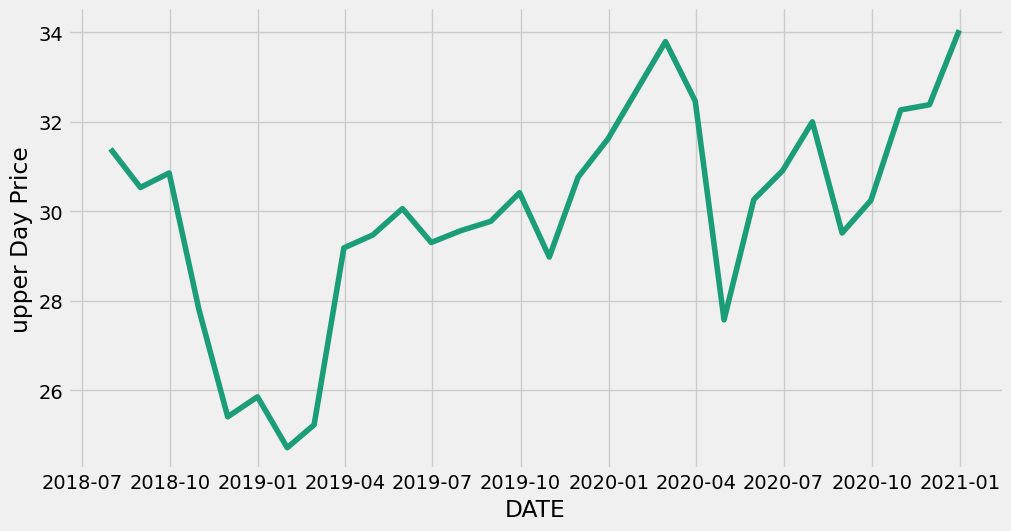

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['DATE']
  ys = series['upper Day Price']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_4.sort_values('DATE', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('DATE')
_ = plt.ylabel('upper Day Price')

**PLOTS FOR THE FORECATS OF OUR DAY PRICE**

<Figure size 1000x600 with 0 Axes>

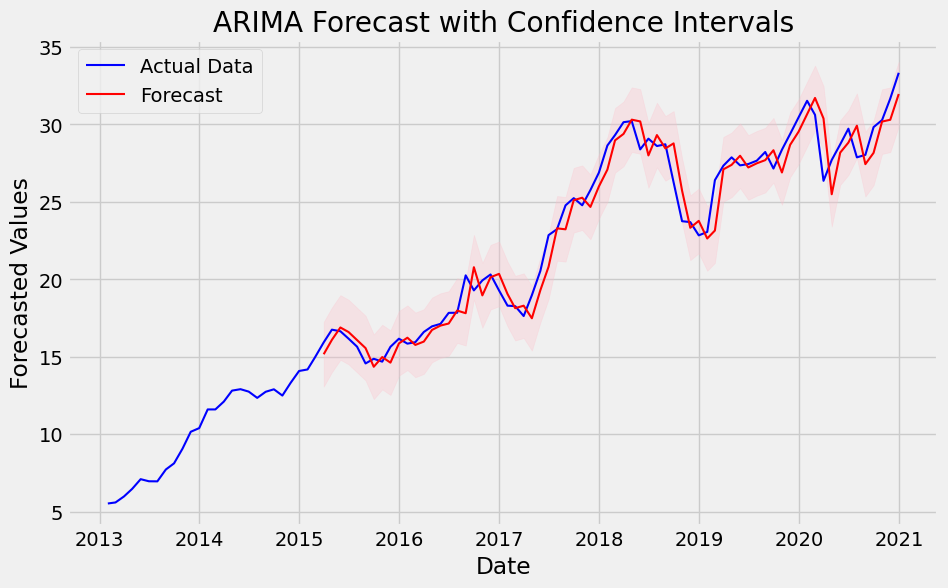

In [ ]:

plt.figure(figsize=(10, 6))

plt.figure(figsize=(10, 6))
plt.plot(monthly_prices.index, monthly_prices['Day Price'], label='Actual Data', color='blue',  linewidth=1.5)

plt.plot(monthly_prices.index[-70:], mean_forecast.values, color='red', label='Forecast',  linewidth=1.5)
plt.fill_between(monthly_prices.index[-70:], confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='pink', alpha=0.3)
plt.xlabel('Date')
plt.ylabel('Forecasted Values')
plt.title('ARIMA Forecast with Confidence Intervals')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [ ]:
monthly_prices.head()

,Day Price,Day Price_diff,Day Price_change
DATE,,,
2013-01-31,5.525000,NaN,0.292703
2013-02-28,5.592500,5.525000,0.067500
2013-03-31,5.978947,5.592500,0.386447
2013-04-30,6.470000,5.978947,0.491053
2013-05-31,7.095455,6.470000,0.625455


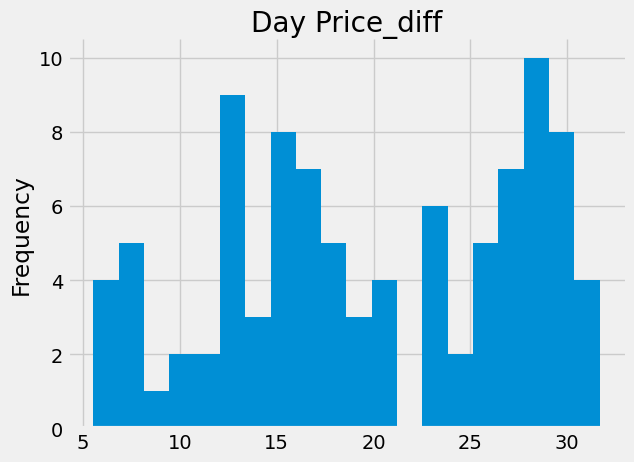

In [ ]:
# @title Day Price_diff

from matplotlib import pyplot as plt
monthly_prices['Day Price_diff'].plot(kind='hist', bins=20, title='Day Price_diff')
plt.gca().spines[['top', 'right',]].set_visible(False)

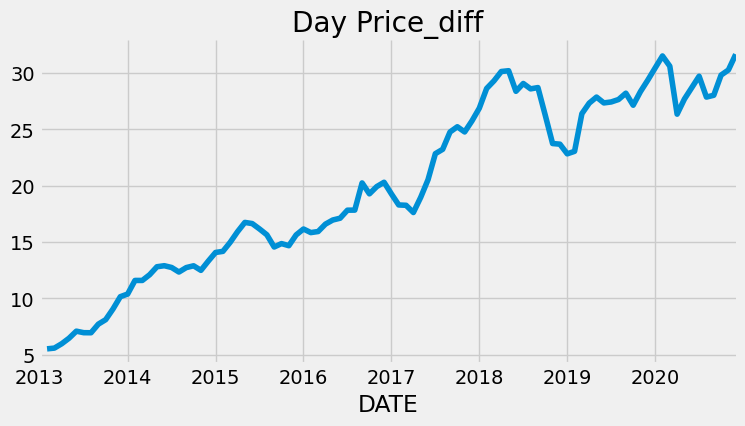

In [ ]:
# @title Day Price_diff

from matplotlib import pyplot as plt
monthly_prices['Day Price_diff'].plot(kind='line', figsize=(8, 4), title='Day Price_diff')
plt.gca().spines[['top', 'right']].set_visible(False)

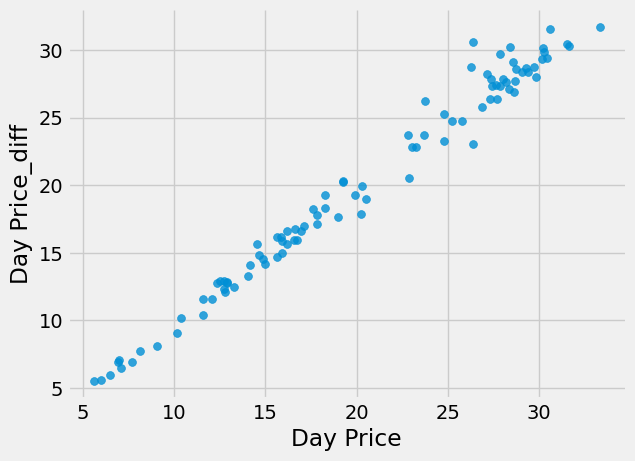

In [ ]:
# @title Day Price vs Day Price_diff

from matplotlib import pyplot as plt
monthly_prices.plot(kind='scatter', x='Day Price', y='Day Price_diff', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

#**SENTIMENT ANALYSIS**

**Importing Libraries**

In [ ]:

import pandas as pd
import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import sent_tokenize
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from textblob import TextBlob
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.graph_objects as go
import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from wordcloud import WordCloud
df = pd.read_excel('https://github.com/Leonard-Simala/Datasets/raw/main/sentimentreports.xlsx')



In [ ]:
df.dropna(inplace=True)

**Preprocessing Steps**

In [ ]:

nltk.download('punkt')
nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()
sentiments = []

for year, group in df.groupby('Year'):
    all_text = ' '.join(group['Text'])
    tokens = word_tokenize(all_text)
    sentiment_score = sid.polarity_scores(all_text)['compound']
    sentiments.append((year, sentiment_score))

# Convert sentiments to DataFrame
sentiments_df = pd.DataFrame(sentiments, columns=['Year', 'Sentiment']).set_index('Year')



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


**Visualisation of the reports**

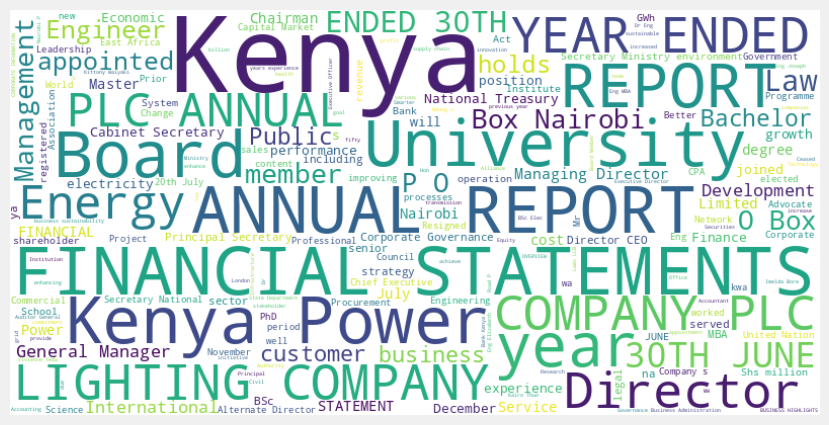

In [ ]:

all_text = ' '.join(df['Text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
from nltk.corpus import stopwords
#nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

# Remove stopwords
def remove_stopwords(sentence):
    words = sentence.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)


In [ ]:
# sentiment analysis using NLTK's Vader
def analyze_sentiment_vader(sentence):
    analyzer = SentimentIntensityAnalyzer()
    scores = analyzer.polarity_scores(sentence)
    compound_score = scores['compound']
    if compound_score >= 0.05:
        return 'Positive'
    elif compound_score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# store sentence-level results
sentiment_df = pd.DataFrame(columns=['Sentence', 'Sentiment', 'Year'])

for index, row in df.iterrows():
    text = row['Text']
    year = row['Year']

    # Tokenize the text into sentences
    sentences = sent_tokenize(text)

    # Perform sentiment analysis for each sentence
    for sentence in sentences:
        # Remove stopwords
        sentence_without_stopwords = remove_stopwords(sentence)

        sentiment_vader = analyze_sentiment_vader(sentence_without_stopwords)

        # Append the results to the new DataFrame
        sentiment_df = sentiment_df.append({'Sentence': sentence_without_stopwords, 'Sentiment': sentiment_vader, 'Year': year}, ignore_index=True)

# Display the resulting DataFrame
sentiment_df.head()


,Sentence,Sentiment,Year
0,Kenya Power Lighting Company Plc Annual Report...,Positive,2019
1,becoming preferred energy solution businesses ...,Positive,2019
2,striving provide world-class products services...,Positive,2019
3,CORE VALUES put customers first matter work to...,Positive,2019
4,report considered shareholders adoption 98th A...,Neutral,2019


In [ ]:
sentiment_df.head()

,Sentence,Sentiment,Year
0,Kenya Power Lighting Company Plc Annual Report...,Positive,2019
1,becoming preferred energy solution businesses ...,Positive,2019
2,striving provide world-class products services...,Positive,2019
3,CORE VALUES put customers first matter work to...,Positive,2019
4,report considered shareholders adoption 98th A...,Neutral,2019


In [ ]:
#Distribution of Sentiments
temp = sentiment_df.groupby('Sentiment').count()['Sentence'].reset_index().sort_values(by='Sentence',ascending=False)
temp.style.background_gradient(cmap='Purples')


,Sentiment,Sentence
1,Neutral,374
2,Positive,232
0,Negative,28


In [ ]:
sentiment_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentence   634 non-null    object
 1   Sentiment  634 non-null    object
 2   Year       634 non-null    object
dtypes: object(3)
memory usage: 15.0+ KB


<Figure size 1200x800 with 0 Axes>

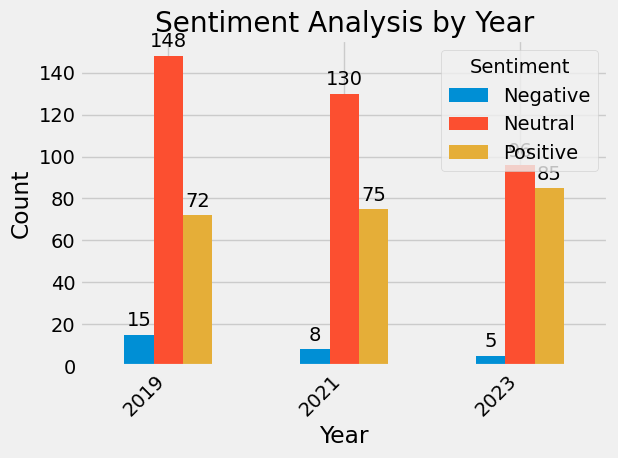

In [ ]:

grouped_df = sentiment_df.groupby(['Year', 'Sentiment']).size().unstack(fill_value=0)


plt.figure(figsize=(12, 8))
ax = grouped_df.plot(kind='bar')
plt.title('Sentiment Analysis by Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Sentiment')

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.tight_layout()
plt.show()

<Figure size 1200x800 with 0 Axes>

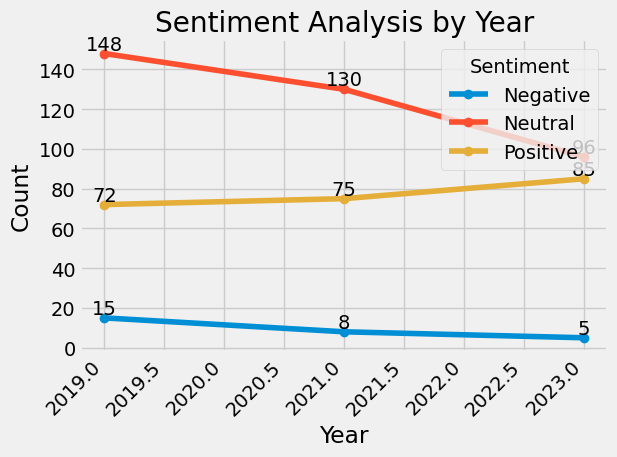

In [ ]:

grouped_df = sentiment_df.groupby(['Year', 'Sentiment']).size().unstack(fill_value=0)

# Plot the sentiments for each year with a larger figure size
plt.figure(figsize=(12, 8))

grouped_df.plot(kind='line', marker='o', linestyle='-')

plt.title('Sentiment Analysis by Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Sentiment')

for year in grouped_df.index:
    for sentiment, count in grouped_df.loc[year].items():
        plt.text(year, count, str(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [ ]:
# count for each year
total_counts = grouped_df.sum(axis=1)

# Relative sentiment count
percentage_df = grouped_df.div(total_counts, axis=0)

percentage_df

Sentiment,Negative,Neutral,Positive
Year,,,
2019,0.063830,0.629787,0.306383
2021,0.037559,0.610329,0.352113
2023,0.026882,0.516129,0.456989


In [ ]:
grouped_df.columns

Index(['Negative', 'Neutral', 'Positive'], dtype='object', name='Sentiment')

In [ ]:
temp.columns

Index(['Sentiment', 'Sentence'], dtype='object')

In [ ]:
fig = go.Figure(go.Funnelarea(
    text =temp.Sentiment,
    values = temp.Sentence,
    title = {"position": "top center", "text": "Sentiment Distribution Funnel-chart"}
    ))
fig.show()

<Axes: xlabel='Sentiment', ylabel='count'>

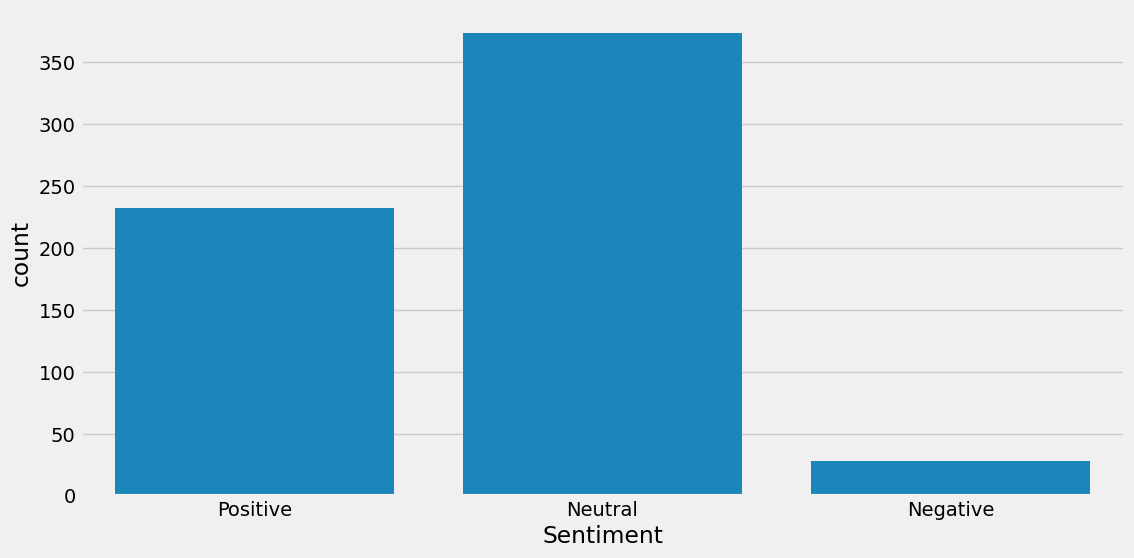

In [ ]:
plt.figure(figsize=(12,6))
sns.countplot(x='Sentiment',data=sentiment_df)

**Common words**

In [ ]:
from collections import Counter
sentiment_df['temp_list'] = sentiment_df['Sentence'].apply(lambda x:str(x).split())
top = Counter([item for sublist in sentiment_df['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,Kenya,114
1,Eng.,70
2,Director,67
3,Board,66
4,&,61
5,REPORT,59
6,Company,58
7,Nairobi,57
8,University,55
9,FINANCIAL,53


In [ ]:
import plotly.express as px
fig = px.bar(temp, x="count", y="Common_words", title='Commmon Words', orientation='h',
             width=700, height=700,color='Common_words')
fig.show()


**Company Location**The word 'Kenya' and 'Nairobi'appears severally  we therefore induce that the company is kenyan based or it performs most of its operations in kenya specifically Nirobi

**shift consumer behaviour towards the company** there is a general shift tward positive sentiments as captured in the line plot.